<a href="https://colab.research.google.com/github/jungry/time_series/blob/main/TimeSeries_Week09_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Google Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_ccf
from sklearn.model_selection import train_test_split
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ValueWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels.tsa.statespace.sarimax")

In [4]:
# Load the synthetic data
data = pd.read_csv('/content/drive/Shareddrives/timeseries-datasets/business_data.csv')
data.head(5)

,date,advertising_expenditure,product_quality,competition,consumer_preferences,market_gain
0,2020-06-01,1248.357077,3.584629,3.357787,3.171005,-151.868532
1,2020-06-02,930.867849,4.579355,3.560785,3.439819,-53.691425
2,2020-06-03,1323.844269,4.657285,4.083051,4.747294,9.090931
3,2020-06-04,1761.514928,4.197723,4.053802,4.610370,15.322909
4,2020-06-05,882.923313,4.838714,1.622331,3.979098,-38.592691


# 1. Data Inspection and Visualization

In [5]:
# Check column names
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     100 non-null    object 
 1   advertising_expenditure  100 non-null    float64
 2   product_quality          100 non-null    float64
 3   competition              100 non-null    float64
 4   consumer_preferences     100 non-null    float64
 5   market_gain              100 non-null    float64
dtypes: float64(5), object(1)
memory usage: 4.8+ KB


In [6]:
# If the data was not into datetime format
data['date'] = pd.to_datetime(data['date'])
#date 열을 datetime 형식으로 변환 -> 시계열 데이터를 더 잘 처리할수 있도록 함 !

In [7]:
# Set 'Date' as index
data = data.set_index('date')

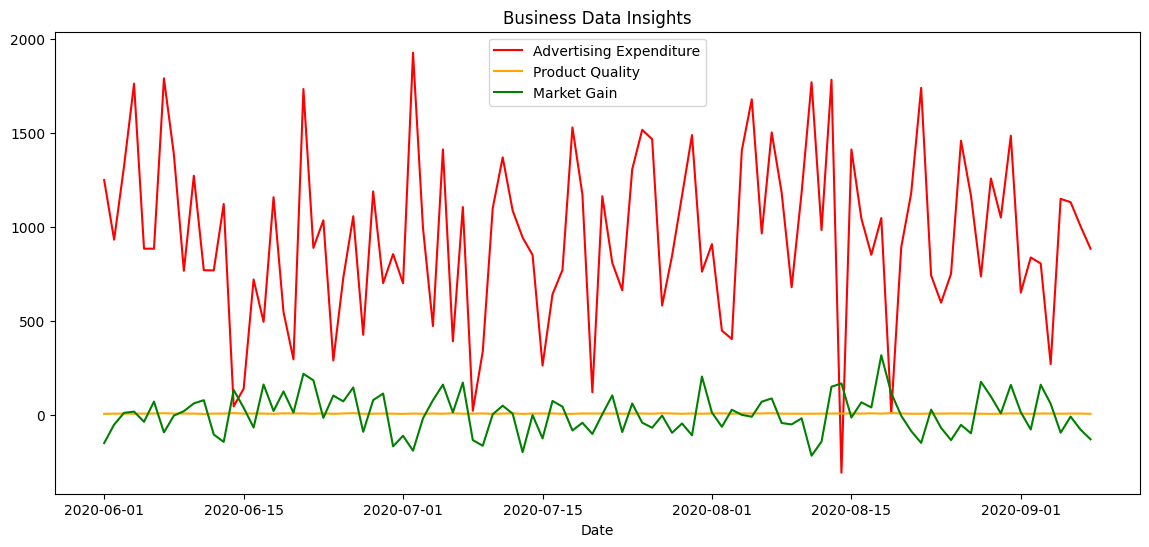

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(data['advertising_expenditure'], label='Advertising Expenditure', color='red')
plt.plot(data['product_quality'], label='Product Quality', color='orange')
#plt.plot(data['competition'], label='Competition', color='blue')
plt.plot(data['market_gain'], label='Market Gain', color='green')
plt.legend()
plt.title('Business Data Insights')
plt.xlabel('Date')
plt.show()

# 2. Stationarity Check with Augmented Dickey-Fuller Test

#### **Recap**
**Definition:** A stationary series has constant mean, variance, and autocorrelation over time, unlike a non-stationary series, which shows trends or changing variance.<br>
**Importance:** Stationarity is key for accurate forecasting in models like ARIMA, as it ensures stable patterns for reliable predictions.<br>
**ADF Test for Stationarity:**
   * **Purpose:** Determines if a series is stationary or has a trend (unit root).
   * **Interpretation:**
        * **Test Statistic:** More negative than critical values (at 1%, 5%, or 10%) suggests stationarity.
        * **p-value:** Less than 0.05 indicates stationarity; higher implies non-stationarity.

정의: 정상(stationary) 시계열은 시간에 따라 평균, 분산 및 자기상관이 일정한 시계열을 의미하며, 비정상(non-stationary) 시계열은 트렌드나 변동성 변화가 나타나는 시계열을 의미함.<br>
중요성: 정상성은 ARIMA와 같은 모델의 정확한 예측을 위해 필수적이며, 안정적인 패턴을 보장하여 신뢰할 수 있는 예측을 가능하게 함.<br>
ADF 정상성 검정:<br>
목적: 시계열이 정상성 여부를 가지는지, 또는 트렌드(단위근)가 존재하는지를 판단.<br>
해석:<br>
•	검정 통계량: 1%, 5%, 10%의 임계값보다 더 부정적인 값이면 정상성을 시사함. <br>
•	p-값: 0.05 미만이면 정상성을 나타내며, 더 높은 값은 비정상성을 나타냄.

In [9]:

#adf_test 함수 정의
def adf_test(series): #파이썬은 매개변수를 정의할때 데이터 유형 정하지 않아도 됨. 그래서 list series가 아니라 그냥 series라고 씀.
    result = sm.tsa.adfuller(series) #series 데이터에 대해 ADF 검정 수행 -> 정상성 여부 판단
    print(f'ADF Statistic: {result[0]:.2f}')
    print(f'p-value: {result[1]:.2f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.2f}')

"""
sm.tsa.adfuller : ADF검정을 수행하여 결과를 반환하는 함수
  •	result[0]: 검정 통계량(ADF Statistic)
	•	result[1]: p-value (정상성 여부를 나타내는 지표)
	•	result[2]: 사용된 랙 수
	•	result[3]: 관측값의 개수
	•	result[4]: 다양한 신뢰수준(1%, 5%, 10%)에서의 임계값(critical values)
	•	result[5]: 최적의 ADF 모델에 대한 추가 정보

"""


'\nsm.tsa.adfuller : ADF검정을 수행하여 결과를 반환하는 함수\n  •\tresult[0]: 검정 통계량(ADF Statistic)\n\t•\tresult[1]: p-value (정상성 여부를 나타내는 지표)\n\t•\tresult[2]: 사용된 랙 수\n\t•\tresult[3]: 관측값의 개수\n\t•\tresult[4]: 다양한 신뢰수준(1%, 5%, 10%)에서의 임계값(critical values)\n\t•\tresult[5]: 최적의 ADF 모델에 대한 추가 정보\n\n'

In [10]:
# Check stationarity of Advertising Expenditure
print("ADF Test for Advertising Expenditure")
print("===========================")
adf_test(data['advertising_expenditure'])

'''
ADF Statistic이 1%임계값인 -3.5보다 작음, p-value < 0.06 -> stationary. ('귀무가설: non-stationary 이다.' 를 기각)
임계값이 10%에서 1%로 갈수록 기준이 더 엄격해짐.
1% 임계값보다 더 작다 : 매우 강한 증거로 stationary.
10%임계값보다 작다: stationary할 가능성 있음.
'''

ADF Test for Advertising Expenditure
ADF Statistic: -10.08
p-value: 0.00
Critical Values:
   1%: -3.50
   5%: -2.89
   10%: -2.58


"\nADF Statistic이 1%임계값인 -3.5보다 작음, p-value < 0.06 -> stationary. ('귀무가설: non-stationary 이다.' 를 기각)\n임계값이 10%에서 1%로 갈수록 기준이 더 엄격해짐. \n1% 임계값보다 더 작다 : 매우 강한 증거로 stationary. \n10%임계값보다 작다: stationary할 가능성 있음.\n"

In [11]:
# Check stationarity of Product Quality
print("\nADF Test for Product Quality")
print("==============================")
adf_test(data['product_quality'])


ADF Test for Product Quality
ADF Statistic: -10.88
p-value: 0.00
Critical Values:
   1%: -3.50
   5%: -2.89
   10%: -2.58


In [12]:
# Check stationarity of Competition
print("\nADF Test for Competition")
print("=======================")
adf_test(data['competition'])


ADF Test for Competition
ADF Statistic: -11.10
p-value: 0.00
Critical Values:
   1%: -3.50
   5%: -2.89
   10%: -2.58


In [13]:
# Check stationarity of Consumer Preferences
print("\nADF Test for Consumer Preferences")
print("=======================")
adf_test(data['consumer_preferences'])


ADF Test for Consumer Preferences
ADF Statistic: -9.25
p-value: 0.00
Critical Values:
   1%: -3.50
   5%: -2.89
   10%: -2.58


In [14]:
# Check stationarity of Market Gain
print("\nADF Test for Market Gain")
print("=======================")
adf_test(data['market_gain'])


ADF Test for Market Gain
ADF Statistic: -8.45
p-value: 0.00
Critical Values:
   1%: -3.50
   5%: -2.89
   10%: -2.58


# 3. Exogeneity Tests

**What is Exogeneity?**<br>
In time series analysis, an exogenous variable is one that influences the primary series but is not influenced by it in return. Exogeneity tests help confirm if a variable can act as an independent predictor in forecasting models without feedback from the primary series.

**Why is Exogeneity Important?**<br>
Identifying exogenous variables improves model accuracy by allowing only true independent variables to inform the primary series. Properly identifying exogenous variables helps avoid biases in predictions and enables clearer insights into cause-effect relationships.

## 3.1 Granger Causality Test:

**Purpose:** Checks if past values of one time series can predict future values of another, indicating a directional influence.<br>
**Hypotheses:**
* Null Hypothesis (H₀): The exogenous variable does not Granger-cause the primary series.
* Alternative Hypothesis: The exogenous variable Granger-causes the primary series.

**Interpretation:**<br>
A p-value < 0.05 suggests rejecting the null hypothesis, indicating that the exogenous variable influences the primary series, supporting exogeneity.

**외생성 테스트**

**외생성(Exogeneity)이란?**<br>
시계열 분석에서 외생 변수란 주요 시계열에 영향을 미치지만, 그에 반대의 영향을 받지 않는 변수를 의미함.<br> 외생성 테스트는 특정 변수가 예측 모델에서 독립적인 예측자로 작용할 수 있는지, 즉 주요 시계열에 의해 피드백을 받지 않는지를 확인하는 데 도움을 줌.<br>

쉽게 말해, 외생 변수는 어떤 시스템이나 시계열에 영향을 주지만, 그 반대로 그 시스템이나 시계열에 의해 영향을 받지는 않는 변수. 예를 들어, 날씨가 상품 판매량에 영향을 줄 수는 있지만, 상품 판매량이 날씨에 영향을 주지 않는다면 날씨가 외생 변수라고 할 수 있음! 즉, 외생 변수는 주로 독립적인 요인으로 작용하면서 결과에 영향을 미치지만 그 결과에 의해 변화하지 않는 것을 의미한다~

**왜 외생성이 중요한가?**<br>
외생 변수를 식별하면 진정한 독립 변수를 주요 시계열에 반영하여 모델의 정확성을 높일 수 있음!<br> 외생 변수를 제대로 식별하면 예측에서의 편향을 방지하고 원인-결과 관계를 명확하게 이해할 수 있음.<br>

**3.1 그랜저 인과성 검정** (Granger Causality Test)<br>
목적:한 시계열의 과거 값이 다른 시계열의 미래 값을 예측할 수 있는지를 확인하여 방향성을 가진 영향을 나타내는지 검사.<br>

**가설**:<br>

•	귀무가설 (H₀): 외생 변수는 주요 시계열에 대해 그랜저 인과성을 가지지 않는다.<br>
•	대립가설: 외생 변수는 주요 시계열에 대해 그랜저 인과성을 가진다.<br>

**해석**:<br>
p-값이 0.05보다 작으면 귀무가설을 기각하고 외생 변수가 주요 시계열에 영향을 미친다고 결론지어 외생성을 지지할 수 있음.<br>

자 예시 들어간다 ~~<br>
상황: A라는 시계열(예: 과거의 광고비 지출)과 B라는 시계열(예: 미래의 판매량)이 있다고 해.

	1.	그랜저 인과성 검정의 목적: A의 과거 광고비가 B의 미래 판매량에 영향을 미치는지 알고 싶어. 즉, “광고비가 늘어나면 판매량이 증가할까?“를 테스트하는 거임.
	2.	가설:
	•	귀무가설 (H₀): “광고비가 판매량에 영향을 주지 않는다.” (즉, 광고비와 판매량은 관련이 없다.)
	•	대립가설: “광고비가 판매량에 영향을 준다.” (즉, 광고비가 증가하면 판매량도 증가한다.)
	3.	테스트 과정:
	•	과거 광고비 데이터(A)를 사용해 판매량 데이터(B)가 얼마나 잘 예측되는지 분석함.
	•	그랜저 검정을 통해 p-값을 계산함.
	4.	해석:
	•	만약 p-값이 0.05보다 작으면, 귀무가설을 기각함. 즉, “광고비가 판매량에 영향을 준다”는 결론을 내림.
	•	반대로 p-값이 0.05보다 크면, 귀무가설을 받아들이고 “광고비와 판매량은 관련이 없다”는 결론을 내림.

이렇게 해서 어떤 변수가 다른 변수에 영향을 미치는지 확인할 수 있는 거임.

### **Syntax:**
```
grangercausalitytests(data, maxlag, addconst=True, verbose=True)
```
**data:** A two-dimensional array-like object (e.g., DataFrame) where the first column is the dependent variable (Y) and the second column is the exogenous variable (X) that might Granger-cause Y.

**maxlag:** The maximum number of lags to test for Granger causality. This is an integer, and the test will go from 1 up to maxlag lags.

**addconst (optional):** A boolean that determines whether a constant should be added to the regression model. Default is True.

**verbose (optional):** A boolean that controls whether to print the test results for each lag. Default is True.


### **How to read:**
**Hypotheses Setup:**
* For a variable 𝑋 to be considered exogenous relative to another variable 𝑌 (your primary series), 𝑋 should Granger-cause 𝑌 (i.e., influence 𝑌), but 𝑌 should not Granger-cause 𝑋.
* Conversely, if 𝑌 Granger-causes 𝑋, then 𝑋 is likely endogenous to 𝑌, meaning they influence each other, or 𝑋 depends on 𝑌.

**Significant Tests:**
* F-test: Tests the significance of the lagged values of the exogenous variable in predicting the dependent variable.
* Chi-squared test: Tests whether lagged values jointly add predictive value.

**Apply Granger Causality Test in Both Directions:**
* Test 1: Does 𝑋 Granger-cause 𝑌 ?
    * *Null Hypothesis:* 𝑋 does not Granger-cause 𝑌.
* Test 2: Does 𝑌 Granger-cause 𝑋?
    * *Null Hypothesis:* 𝑌 does not Granger-cause 𝑋.

**Interpret the Results:**
* Exogenous Variable: If the p-value for Test 1 (𝑋 → 𝑌) is less than 0.05 (indicating causality), but the p-value for Test 2 (𝑌 → 𝑋) is greater than 0.05, 𝑋 can be considered exogenous because it influences 𝑌 but is not influenced by it.
* Endogenous Variable: If the p-values are both below 0.05, there is mutual causation, suggesting that 𝑋 and 𝑌 influence each other. This makes 𝑋 an endogenous variable in relation to 𝑌.

Syntax:
grangercausalitytests(data, maxlag, addconst=True, verbose=True)

data: 두 개의 차원을 가진 배열 같은 객체(예: DataFrame)로, 첫 번째 열은 종속 변수(Y)이고 두 번째 열은 Y에 대해 그랜저 인과성을 가질 수 있는 외생 변수(X)임.

maxlag: 그랜저 인과성 검정을 위한 최대 지연 수. 정수형이며, 테스트는 1부터 maxlag까지의 지연을 검사함.

addconst (선택적): 회귀 모델에 상수를 추가할지 여부를 결정하는 불리언. 기본값은 True.

verbose (선택적): 각 지연에 대한 테스트 결과를 출력할지 여부를 제어하는 불리언. 기본값은 True.

읽는 방법:

가설 설정:

변수 𝑋가 다른 변수 𝑌(주요 시계열)에 대해 외생 변수로 간주되기 위해서는 𝑋가 𝑌를 그랜저 인과해야(즉, 𝑌에 영향을 미쳐야 하며), 𝑌는 𝑋를 그랜저 인과하지 않아야 함.
반대로, 𝑌가 𝑋를 그랜저 인과하면 𝑋는 𝑌에 대해 내생적일 가능성이 높으며, 이는 두 변수가 서로 영향을 미치거나 𝑋가 𝑌에 의존함을 의미함.

유의미한 테스트:

F-test: 종속 변수를 예측하는 데 있어 외생 변수의 지연 값의 유의성을 테스트함.
Chi-squared test: 지연 값들이 공동으로 예측 가치를 추가하는지를 테스트함.

양 방향으로 그랜저 인과성 검정 적용:

테스트 1: 𝑋가 𝑌를 그랜저 인과하는가?<br>
귀무가설: 𝑋는 𝑌를 그랜저 인과하지 않는다.<br>
테스트 2: 𝑌가 𝑋를 그랜저 인과하는가?<br>
귀무가설: 𝑌는 𝑋를 그랜저 인과하지 않는다.<br>

결과 해석:

외생 변수: 테스트 1(𝑋 → 𝑌)의 p-값이 0.05 미만(인과성을 나타냄)이지만, 테스트 2(𝑌 → 𝑋)의 p-값이 0.05보다 크면, 𝑋는 𝑌에 영향을 미치지만 𝑌에 의해 영향을 받지 않으므로 외생 변수로 간주될 수 있음.

내생 변수: p-값이 모두 0.05 미만이면 상호 인과성이 있으며, 𝑋와 𝑌가 서로 영향을 미친다고 제안함. 이는 𝑋가 𝑌에 대해 내생 변수임을 의미함.

In [26]:
# Test if advertising_expenditure Granger->causes market_gain
print("\nGranger Causality Test: Advertising Expenditure -> Market Gain")
granger_test_1a = grangercausalitytests(data[['advertising_expenditure', 'market_gain']], maxlag=2) #자동출력되는 함수임
print("=====================================================================================")

# Test if market_gain Granger->causes advertising_expenditure
print("\nGranger Causality Test: Market Gain -> Advertising Expenditure")
granger_test_1b = grangercausalitytests(data[['market_gain', 'advertising_expenditure']], maxlag=2)


Granger Causality Test: Advertising Expenditure -> Market Gain

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6414  , p=0.0337  , df_denom=96, df_num=1
ssr based chi2 test:   chi2=4.7864  , p=0.0287  , df=1
likelihood ratio test: chi2=4.6743  , p=0.0306  , df=1
parameter F test:         F=4.6414  , p=0.0337  , df_denom=96, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2905  , p=0.1069  , df_denom=93, df_num=2
ssr based chi2 test:   chi2=4.8272  , p=0.0895  , df=2
likelihood ratio test: chi2=4.7121  , p=0.0948  , df=2
parameter F test:         F=2.2905  , p=0.1069  , df_denom=93, df_num=2

Granger Causality Test: Market Gain -> Advertising Expenditure

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1550  , p=0.6947  , df_denom=96, df_num=1
ssr based chi2 test:   chi2=0.1598  , p=0.6893  , df=1
likelihood ratio test: chi2=0.1597  , p=0.6895  , df=1
parameter F test:         F=0.1550  , p=0.69

In [16]:
# Test if advertising_expenditure Granger-causes market_gain
print("\nGranger Causality Test: Advertising Expenditure -> Competition")
granger_test_1a = grangercausalitytests(data[['advertising_expenditure', 'competition']], maxlag=2)
print("=====================================================================================")

# Test if market_gain Granger-causes advertising_expenditure
print("\nGranger Causality Test: Competition -> Advertising Expenditure")
granger_test_1b = grangercausalitytests(data[['competition', 'advertising_expenditure']], maxlag=2)


Granger Causality Test: Advertising Expenditure -> Competition

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0881  , p=0.7672  , df_denom=96, df_num=1
ssr based chi2 test:   chi2=0.0909  , p=0.7630  , df=1
likelihood ratio test: chi2=0.0909  , p=0.7631  , df=1
parameter F test:         F=0.0881  , p=0.7672  , df_denom=96, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0547  , p=0.9468  , df_denom=93, df_num=2
ssr based chi2 test:   chi2=0.1154  , p=0.9439  , df=2
likelihood ratio test: chi2=0.1153  , p=0.9440  , df=2
parameter F test:         F=0.0547  , p=0.9468  , df_denom=93, df_num=2

Granger Causality Test: Competition -> Advertising Expenditure

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0451  , p=0.8322  , df_denom=96, df_num=1
ssr based chi2 test:   chi2=0.0465  , p=0.8292  , df=1
likelihood ratio test: chi2=0.0465  , p=0.8292  , df=1
parameter F test:         F=0.0451  , p=0.83

# 4. Modelling

## 4.1 ARIMAX
**ARIMAX** stands for AutoRegressive Integrated Moving Average with Exogenous Variables, an extension of the ARIMA model that incorporates external (exogenous) factors to improve forecasting accuracy. It is used for modeling time series data where external influences impact future values of the primary series.

**Key Parameters of ARIMA:**
- <u>p (AutoRegressive part):</u> The number of lag observations included.
- <u>d (Integrated part):</u> The number of differencing steps required to make the series stationary.
- <u>q (Moving Average part):</u> The number of lagged forecast errors included.
- <u>Exogenous Variables:</u> In addition to the ARIMA components, ARIMAX includes one or more exogenous variables (independent predictors) that influence the primary series, helping to account for factors outside the series itself.

4.1 ARIMAX
ARIMAX는 외생 변수를 포함한 자기 회귀 적분 이동 평균 모델(ARIMA)의 확장으로, 외부(외생) 요인을 포함하여 예측 정확성을 향상시킴. 이는 외부 영향이 주요 시계열의 미래 값에 영향을 미치는 시계열 데이터 모델링에 사용됨.

ARIMA의 주요 매개변수:

	•	p (자기 회귀 부분): 포함되는 지연 관측치의 수.
	•	d (적분 부분): 시계열을 정상화하기 위해 필요한 차분 단계의 수.
	•	q (이동 평균 부분): 포함되는 지연된 예측 오류의 수.

외생 변수: ARIMAX는 ARIMA 구성 요소 외에 주요 시계열에 영향을 미치는 하나 이상의 외생 변수를 포함하여 시계열 자체 외부의 요인을 고려하는 데 도움을 줌!

In [17]:
# Use tourists_visits as the exogenous variable and room_occupancy_diff as the dependent variable
#처음 80%는 훈련 데이터, 나머지 20%는 테스트 데이터
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False) #데이터 분할 시 데이터를 섞지 않음 (시계열에서는 순서가 중요)
train_exog = train_data[['market_gain']]
#훈련 데이터에서 외생 변수인 market_gain을 가져옴
test_exog = test_data[['market_gain']] #exogeneity로 이용할 변수. 위에서 granger causality test의 p-value가 0.05보다 작았음.

In [18]:
# Define the p, d, and q parameters.각각의 범위를 0부터 2까지 설정함. 즉, p, d, q의 총 27가지 조합을 테스트할 예정
p = range(0, 3)
d = range(0, 3)
q = range(0, 3)

# Generate combinations of p, d, q triplets. p, d, q의 모든 조합을 생성 후 리스트 형태로 변환
pdq = list(itertools.product(p, d, q))

# DataFrame to store results. 결과를 저장할 데이터프레임 준비
results = []

# Grid search over ARIMAX parameters
for param in pdq:
    try:
        # Fit ARIMAX model with exogenous variable(s) (e.g., exog=train_exog).
        #주어진 advertising_expenditure 데이터에 ARIMA 모델을 적용함. order=param으로 이전에 생성한 조합을 사용하고, 외생 변수로 train_exog를 사용
        temp_model = ARIMA(train_data['advertising_expenditure'], order=param, exog=train_exog)
        temp_result = temp_model.fit()

        # Store parameters and AIC(모델의 적합도를 평가함)
        results.append([param, temp_result.aic])
    except Exception as e:
        continue

# Convert results to DataFrame and sort by AIC
results_df = pd.DataFrame(results, columns=['parameters', 'AIC'])
#AIC 값에 따라 데이터프레임을 정렬. AIC 값이 낮을수록 모델의 성능이 더 좋음을 나타냄, 정렬 후 인덱스를 초기화
results_df = results_df.sort_values(by='AIC').reset_index(drop=True)

print("Optimal ARIMAX parameters and AIC values:")
print(results_df)

Optimal ARIMAX parameters and AIC values:
   parameters          AIC
0   (0, 2, 2)  1205.916242
1   (1, 2, 2)  1207.694981
2   (0, 1, 1)  1208.398331
3   (2, 2, 2)  1209.437306
4   (0, 1, 2)  1210.284247
5   (1, 1, 1)  1210.284527
6   (1, 1, 2)  1210.806848
7   (2, 1, 2)  1212.065617
8   (2, 1, 1)  1212.283691
9   (0, 0, 0)  1218.589982
10  (2, 0, 2)  1219.907890
11  (0, 0, 1)  1220.388535
12  (1, 0, 0)  1220.394533
13  (2, 2, 1)  1220.751876
14  (2, 0, 1)  1222.095980
15  (1, 0, 2)  1222.190030
16  (0, 0, 2)  1222.373893
17  (1, 0, 1)  1222.379958
18  (2, 0, 0)  1222.390221
19  (2, 1, 0)  1228.173178
20  (1, 2, 1)  1228.868847
21  (1, 1, 0)  1236.875307
22  (0, 2, 1)  1248.888686
23  (0, 1, 0)  1258.128310
24  (2, 2, 0)  1259.181566
25  (1, 2, 0)  1285.032829
26  (0, 2, 0)  1327.938658


In [19]:
# Define and fit the ARIMAX model
arimax_model = ARIMA(train_data['advertising_expenditure'], order=(0, 2, 2), exog=train_exog)
arimax_fit = arimax_model.fit()
print(arimax_fit.summary()) #summary() 메서드: 모델의 요약 통계를 출력

#AIC/BIC 낮을수록 모델이 데이터를 잘 설명한다는 의미.
#market_gain 계수 음수 : advertising_expenditure에 부정적인영향을 끼친다는 의미. BUT p-value > 0.05 이므로 통계적으로 의미 없다!
#즉, 시장 성장률이 광고 지출에 부정적인 영향을 미치지만, 그 영향이 통계적으로 신뢰할 수 있는 수준은 아님.
#Ljung-Box (L1) (Q): 0.43, p-값: 0.51. -> 잔차에 자기상관이 있는지를 확인. p-값 > 0.05 :잔차가 독립적이라는 뜻.

                                  SARIMAX Results                                  
Dep. Variable:     advertising_expenditure   No. Observations:                   80
Model:                      ARIMA(0, 2, 2)   Log Likelihood                -598.958
Date:                     Thu, 07 Nov 2024   AIC                           1205.916
Time:                             10:29:13   BIC                           1215.343
Sample:                         06-01-2020   HQIC                          1209.690
                              - 08-19-2020                                         
Covariance Type:                       opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
market_gain    -0.3871      0.451     -0.859      0.390      -1.271       0.496
ma.L1          -1.9392      0.161    -12.020      0.000      -2.255      -1.623
ma.L2   

In [20]:
# Forecasting with ARIMAX
forecast_steps = len(test_data) #테스트 데이터의 길이를 구해서 예측할 단계 수를 설정함. 이 값은 나중에 모델이 얼마나 먼 미래를 예측할지를 결정
#이미 학습한 ARIMAX 모델(arimax_fit)을 사용해 지정된 단계 수만큼 예측을 수행.exog=test_exog를 통해 외생 변수(시장 성장률)를 모델에 포함시킴.
arimax_forecast = arimax_fit.get_forecast(steps=forecast_steps, exog=test_exog)
arimax_forecast_mean = arimax_forecast.predicted_mean#각 시점에서의 예측값을 가져옴
arimax_conf_int = arimax_forecast.conf_int() #예측의 신뢰 구간을 계산해서 반환

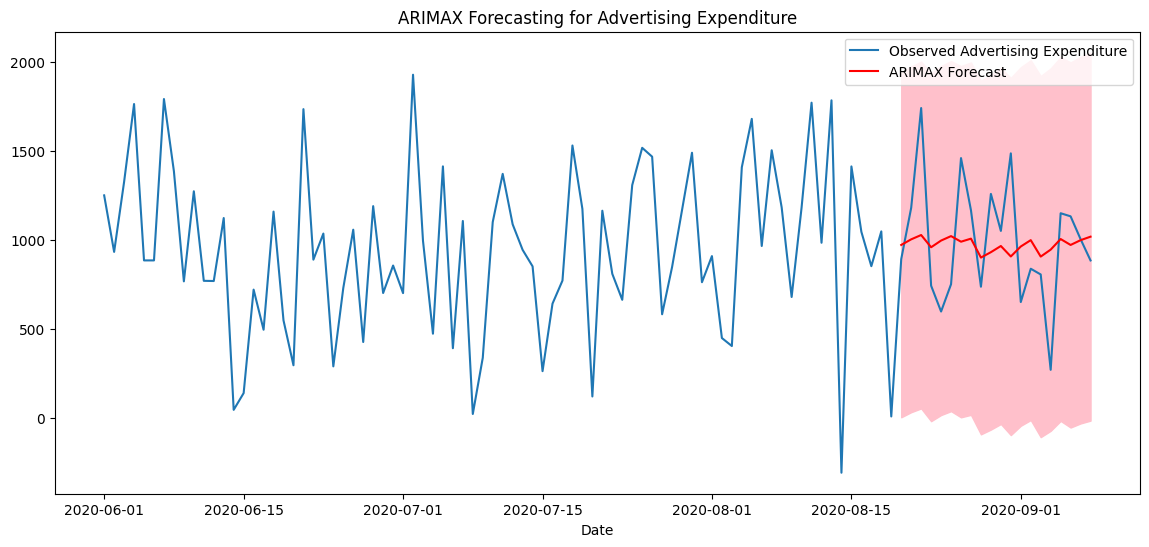

In [21]:
# Plot ARIMAX forecast
plt.figure(figsize=(14, 6))
plt.plot(data['advertising_expenditure'], label='Observed Advertising Expenditure')
plt.plot(arimax_forecast_mean, color='red', label='ARIMAX Forecast')
plt.fill_between(arimax_conf_int.index,
                 arimax_conf_int.iloc[:, 0],
                 arimax_conf_int.iloc[:, 1], color='pink')
plt.legend()
plt.title('ARIMAX Forecasting for Advertising Expenditure')
plt.xlabel('Date')
plt.show()


## 4.2 SARIMAX
**SARIMAX** stands for Seasonal AutoRegressive Integrated Moving Average with Exogenous Variables, an extension of the ARIMA model that incorporates both seasonal components and external (exogenous) factors to improve forecasting accuracy. It is used for modeling time series data that exhibit both seasonality and external influences impacting future values of the primary series.

**Key Components of SARIMAX:** <br>
* <u>p (AutoRegressive part):</u> The number of lag observations of the primary series.
* <u>d (Integrated part):</u> The number of differencing steps needed to make the primary series stationary.
* <u>q (Moving Average part):</u> The number of lagged forecast errors included.
* **Seasonal Components:**
    * <u> P (Seasonal AutoRegressive part):</u> The number of seasonal lag observations.
    * <u> D (Seasonal Differencing part):</u> The number of seasonal differencing steps required.
    * <u> Q (Seasonal Moving Average part):</u> The number of lagged seasonal forecast errors included.
    * <u> m (Seasonal Period):</u> The number of time periods in a season (e.g., 12 for monthly data with yearly seasonality).
    * <u> Exogenous Variables:</u> In addition to the seasonal ARIMA components, SARIMAX includes one or more exogenous variables (independent predictors) that influence the primary series, allowing the model to account for external factors outside the series itself, as well as seasonal effects within the data.

In [22]:
# Define the p, d, q parameters for the regular ARIMA part
p = range(0, 3)
d = range(0, 3)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Define the P, D, Q parameters for the seasonal part and try two seasonal periods
P = range(0, 3)
D = range(0, 2)
Q = range(0, 3)
seasonal_periods = [12]

# DataFrame to store results
results = []

# Grid search over SARIMAX parameters with multiple seasonal periods
for param in pdq:
    for seasonal_m in seasonal_periods:
        seasonal_pdq = [(x[0], x[1], x[2], seasonal_m) for x in itertools.product(P, D, Q)]
        for seasonal_param in seasonal_pdq:
            try:
                # Fit SARIMAX model with exogenous variable(s) (e.g., exog=train_exog)
                temp_model = SARIMAX(train_data['advertising_expenditure'],
                                     order=param,
                                     seasonal_order=seasonal_param,
                                     exog=train_exog)
                temp_result = temp_model.fit(disp=False)  # disp=False suppresses output

                # Store parameters and AIC
                results.append([param, seasonal_param, temp_result.aic])
            except Exception as e:
                continue

# Convert results to DataFrame and sort by AIC
results_df = pd.DataFrame(results, columns=['SARIMAX parameters', 'Seasonal parameters', 'AIC'])
results_df = results_df.sort_values(by='AIC').reset_index(drop=True)

print("Optimal SARIMAX parameters and AIC values:")
print(results_df)

Optimal SARIMAX parameters and AIC values:
    SARIMAX parameters Seasonal parameters          AIC
0            (0, 2, 1)       (2, 0, 1, 12)    12.000000
1            (2, 0, 1)       (2, 0, 1, 12)    16.000000
2            (1, 2, 2)       (0, 1, 1, 12)  1044.126550
3            (0, 2, 2)       (0, 1, 2, 12)  1044.484476
4            (0, 2, 2)       (0, 1, 1, 12)  1045.453688
..                 ...                 ...          ...
478          (0, 2, 0)       (1, 0, 1, 12)  1331.398522
479          (0, 2, 0)       (1, 0, 2, 12)  1331.401885
480          (0, 2, 0)       (2, 0, 2, 12)  1335.013703
481          (0, 2, 0)       (0, 0, 2, 12)  1335.940087
482          (0, 0, 0)       (0, 0, 0, 12)  1344.354247

[483 rows x 3 columns]


In [23]:
# Define the SARIMAX parameters
order = (1, 2, 2)
seasonal_order = (0, 1, 1, 12)

# Fit the SARIMAX model with exogenous variables if available (e.g., exog=train_exog)
sarimax_model = SARIMAX(train_data['advertising_expenditure'], order=order, seasonal_order=seasonal_order, exog=train_exog)
sarimax_fit = sarimax_model.fit()

# Print the summary of the fitted model
print(sarimax_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:              advertising_expenditure   No. Observations:                   80
Model:             SARIMAX(1, 2, 2)x(0, 1, [1], 12)   Log Likelihood                -516.063
Date:                              Thu, 07 Nov 2024   AIC                           1044.127
Time:                                      10:40:16   BIC                           1057.264
Sample:                                  06-01-2020   HQIC                          1049.318
                                       - 08-19-2020                                         
Covariance Type:                                opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
market_gain    -0.5380      0.624     -0.862      0.389      -1.762       0.686
ar.L1          -

In [24]:
# Forecasting with SARIMAX
sarimax_forecast = sarimax_fit.get_forecast(steps=forecast_steps, exog=test_exog)
sarimax_forecast_mean = sarimax_forecast.predicted_mean
sarimax_conf_int = sarimax_forecast.conf_int()

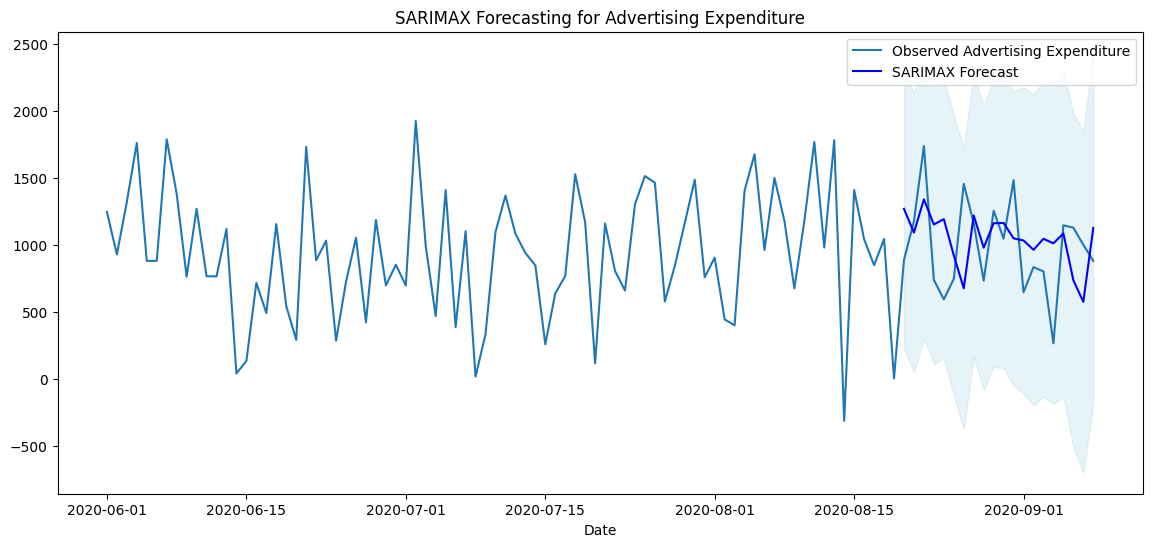

In [25]:
# Plot SARIMAX forecast
plt.figure(figsize=(14, 6))
plt.plot(data['advertising_expenditure'], label='Observed Advertising Expenditure')
plt.plot(sarimax_forecast_mean, color='blue', label='SARIMAX Forecast')
plt.fill_between(sarimax_conf_int.index,
                 sarimax_conf_int.iloc[:, 0],
                 sarimax_conf_int.iloc[:, 1], color='lightblue', alpha=0.3)
plt.legend()
plt.title('SARIMAX Forecasting for Advertising Expenditure')
plt.xlabel('Date')
plt.show()